    
# VAE Data Scaling Problem

# Imports and Model

In [27]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives
from sklearn import preprocessing

In [9]:
# VAE Model - from: https://github.com/twairball/keras_lstm_vae/blob/master/lstm_vae/vae.py
def create_lstm_vae(input_dim, 
    timesteps, 
    batch_size, 
    intermediate_dim, 
    latent_dim,
    epsilon_std=1.):

    """
    Creates an LSTM Variational Autoencoder (VAE). Returns VAE, Encoder, Generator. 
    # Arguments
        input_dim: int.
        timesteps: int, input timestep dimension.
        batch_size: int.
        intermediate_dim: int, output shape of LSTM. 
        latent_dim: int, latent z-layer shape. 
        epsilon_std: float, z-layer sigma.
    # References
        - [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
        - [Generating sentences from a continuous space](https://arxiv.org/abs/1511.06349)
    """
    x = Input(shape=(timesteps, input_dim,))

    # LSTM encoding
    h = LSTM(intermediate_dim)(x)

    # VAE Z layer
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim),
                                  mean=0., stddev=epsilon_std)
        return z_mean + z_log_sigma * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    # so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    # decoded LSTM layer
    decoder_h = LSTM(intermediate_dim, return_sequences=True)
    decoder_mean = LSTM(input_dim, return_sequences=True)

    h_decoded = RepeatVector(timesteps)(z)
    h_decoded = decoder_h(h_decoded)

    # decoded layer
    x_decoded_mean = decoder_mean(h_decoded)
    
    # end-to-end autoencoder
    vae = Model(x, x_decoded_mean)

    # encoder, from inputs to latent space
    encoder = Model(x, z_mean)

    # generator, from latent space to reconstructed inputs
    decoder_input = Input(shape=(latent_dim,))

    _h_decoded = RepeatVector(timesteps)(decoder_input)
    _h_decoded = decoder_h(_h_decoded)

    _x_decoded_mean = decoder_mean(_h_decoded)
    generator = Model(decoder_input, _x_decoded_mean)
    
    def vae_loss(x, x_decoded_mean):
        xent_loss = objectives.mse(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = xent_loss + kl_loss
        return loss

    vae.compile(optimizer='rmsprop', loss=vae_loss)
    
    return vae, encoder, generator

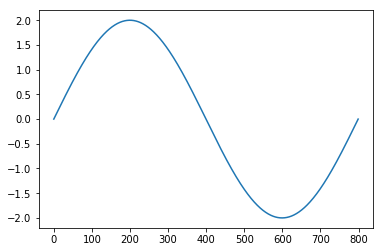

In [10]:
generated_data = 2*np.sin(np.linspace(0,2*np.pi,800))
plt.plot(generated_data)

# set constants for all examples
features = 13
timesteps = 3

# Example 1: No scaling

In [22]:
# sequence data and reshape for RNN
x = generated_data

x = np.array([x[i-features:i] for i in range(features, len(x))])
x = np.array([x[i-timesteps:i,:]for i in range(timesteps, len(x))])
x.shape

(784, 3, 13)

In [ ]:
# run model
input_dim = x.shape[-1] # 13
timesteps = x.shape[1] # 3
batch_size = 1

vae, enc, gen = create_lstm_vae(input_dim,
                                timesteps=timesteps,
                                batch_size=batch_size,
                                intermediate_dim=32,
                                latent_dim=100,
                                epsilon_std=1.)
vae.fit(x, x, epochs=1000)

reconstruct = vae.predict(x, batch_size=batch_size)


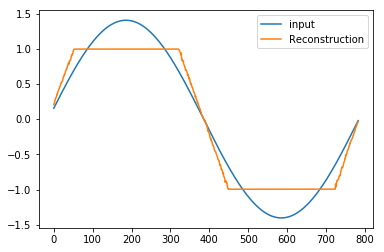

In [30]:
plt.plot(x[:,-1,-1], label="input")
plt.plot(reconstruct[:,-1,-1], label="Reconstruction")
plt.legend()
plt.show()

# Example 2: Standardization

In [29]:
# sequence data and reshape for RNN
x = generated_data

x = np.array([x[i-features:i] for i in range(features, len(x))])

#this time with standardization
scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)


x = np.array([x[i-timesteps:i,:]for i in range(timesteps, len(x))])
x.shape

(784, 3, 13)

In [ ]:
# run model
input_dim = x.shape[-1] # 13
timesteps = x.shape[1] # 3
batch_size = 1

vae, enc, gen = create_lstm_vae(input_dim,
                                timesteps=timesteps,
                                batch_size=batch_size,
                                intermediate_dim=32,
                                latent_dim=100,
                                epsilon_std=1.)
vae.fit(x, x, epochs=1000)

reconstruct = vae.predict(x, batch_size=batch_size)

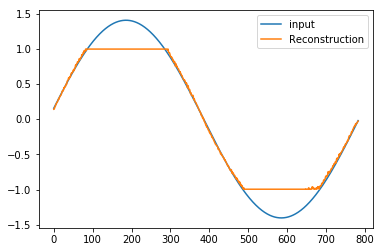

In [32]:
plt.plot(x[:,-1,-1], label="input")
plt.plot(reconstruct[:,-1,-1], label="Reconstruction")
plt.legend()
plt.show()

# Example 3: Normalization

In [52]:
# sequence data and reshape for RNN
x = generated_data

x = np.array([x[i-features:i] for i in range(features, len(x))])
#this time with normalization with the MinMaxScaler => all values between 0 & 1
scaler = preprocessing.MinMaxScaler()
x = scaler.fit_transform(x)

x = np.array([x[i-timesteps:i,:]for i in range(timesteps, len(x))])
x.shape

(784, 3, 13)

In [ ]:
# run model
input_dim = x.shape[-1] # 13
timesteps = x.shape[1] # 3
batch_size = 1

vae, enc, gen = create_lstm_vae(input_dim,
                                timesteps=timesteps,
                                batch_size=batch_size,
                                intermediate_dim=32,
                                latent_dim=100,
                                epsilon_std=1.)
vae.fit(x, x, epochs=1000)

reconstruct = vae.predict(x, batch_size=batch_size)

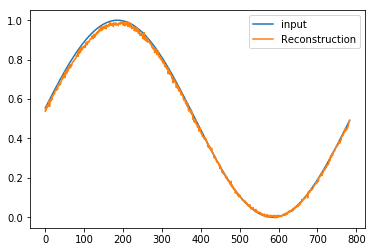

In [54]:
plt.plot(x[:,-1,-1], label="input")
plt.plot(reconstruct[:,-1,-1], label="Reconstruction")
plt.legend()
plt.show()